In [12]:
from numpy.fft import fft2,  fftfreq, fftshift, ifftshift, rfftfreq
from SFS.src.py.utils import *

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150

In [13]:
def get_Cq(seed, folder, start=900, nn=1, sub=''):
    run_folder = folder + "{m}/".format(m = seed) + sub
    X, d, N, L, T, dt, con = get_para(run_folder)

    fn = "varphi"
    field = get_field(run_folder, fn)
    q1 = (fftfreq(N, L / (2 * np.pi * N)))
    q2 = (fftfreq(N, L / (2 * np.pi * N)))
    q1, q2 = np.meshgrid(q1, q2)

    M = len(field)
    n = M - start

    avf = np.zeros_like(fft2(field[0]))
    for i in range(start, M):
        phiq = (fft2(field[i])) * (L / N)**2
        avf += phiq / n

    Cq = np.zeros_like(q1)
    for i in range(start, M):
        phiq = (fft2(field[i])) * (L / N)**2
        Cqi = np.abs(phiq - avf)**2 / L**2
        Cq += Cqi / n
    
    return (q1, q2), (Cq) , con, T, L, N

def average_q(Cqveq, q, N, L):
    Cqveq = Cqveq.flatten()
    absq = np.sqrt(q[0]**2 + q[1]**2).flatten()
    qrange = (0, np.pi * (N + 1)/ L)
    q0 = np.linspace(*qrange, N)
    q0 = rfftfreq(N, L / (2 * np.pi * N))

    # Get index of absq so that q[i-1] < absq[indx[i]] <= q[i]
    indx = np.searchsorted(q0, absq)
    
    Cq = np.zeros(len(q0))
    n = np.zeros(len(q0))  

    for j in range(N**2):
        i = indx[j]
        if (i<len(q0)) & (Cqveq[j]>1e-20): Cq[i] += Cqveq[j]; n[i] += 1

    empty = (n==0.)
    Cq[~empty] = Cq[~empty] / n[~empty]
    Cq[empty] = 0

    return Cq, q0


In [14]:
def get_data_single(seed, folder, start, sub=''): 
        q, Cqvec, con, T, L, N = get_Cq(seed, folder, start=start, sub=sub)
        mask = ((q[0]==0) & (q[1]==0))
        q2 = q[0]**2 + q[1]**2
        mask = mask | (Cqvec < 1e-15)
        CqvecMasked = np.ma.array(Cqvec, mask=mask)
        lim = [np.min(np.abs(CqvecMasked)), np.max(np.abs(CqvecMasked))]

        return (q, Cqvec, CqvecMasked, con, T, L, N, lim)

def get_data(folder, start=200, sub=''):
    n = count_files(folder)

    seeds = range(1, n + 1)
    data = []
    lims = [np.inf, 0.]

    for seed in seeds:
        d = get_data_single(seed, folder, start, sub=sub)
        data.append(d)
        
        lims[0] = min(lims[0], d[7][0])
        lims[1] = max(lims[1], d[7][1])

    return data, lims, n

In [15]:
number = 3

folder = "data/SETD1/{number}/".format(number = number) 
# folder = "/data.lmp/mjohnsrud/SETD1/{n}/".format(n=number)
time = get_time(folder + "1/")
n = count_files(folder)
print(n)
n = 24

36


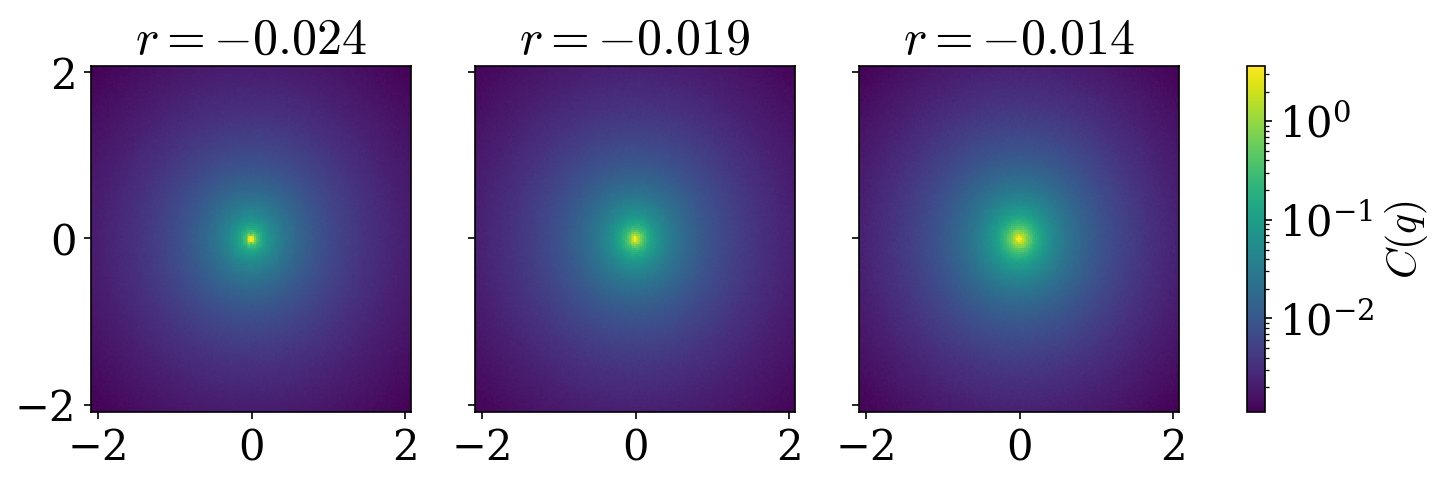

In [16]:
nn = 10
size = 3
inds = range(0,n,nn)
m = len(inds)
fig2, ax2 = plt.subplots(1, m, figsize=(size*(m)*1.3, size), sharey=True) 
ax2 = np.atleast_1d(ax2)

shft = lambda x: fftshift(x)

lim = (np.inf, 0)
for i in inds:
    limi = get_data_single(i + 1, folder, 10)[-1]
    lim = [min(limi[0], lim[0]), max(limi[1], lim[1])]

for j, i in enumerate(inds):
    q, Cqvec, CqvecMasked, con, T, L, N, lim = get_data_single(i + 1, folder, 10)
    r = con["r"]

    cmap = cm.viridis
    p = ax2[j].pcolor(shft(q[0]), shft(q[1]), shft(Cqvec), cmap=cmap, norm=colors.LogNorm(*lim))
    title = "$r= {r:.3f}$".format(r=r)

    ax2[j].set_title(title)

    mm = np.array([np.min(q[0]), np.max(q[0])])  * (2/3)
    ax2[j].set_xlim(*mm)
    ax2[j].set_ylim(*mm)

fig2.colorbar(p, label="$C(q)$", ax=ax2.ravel().tolist())

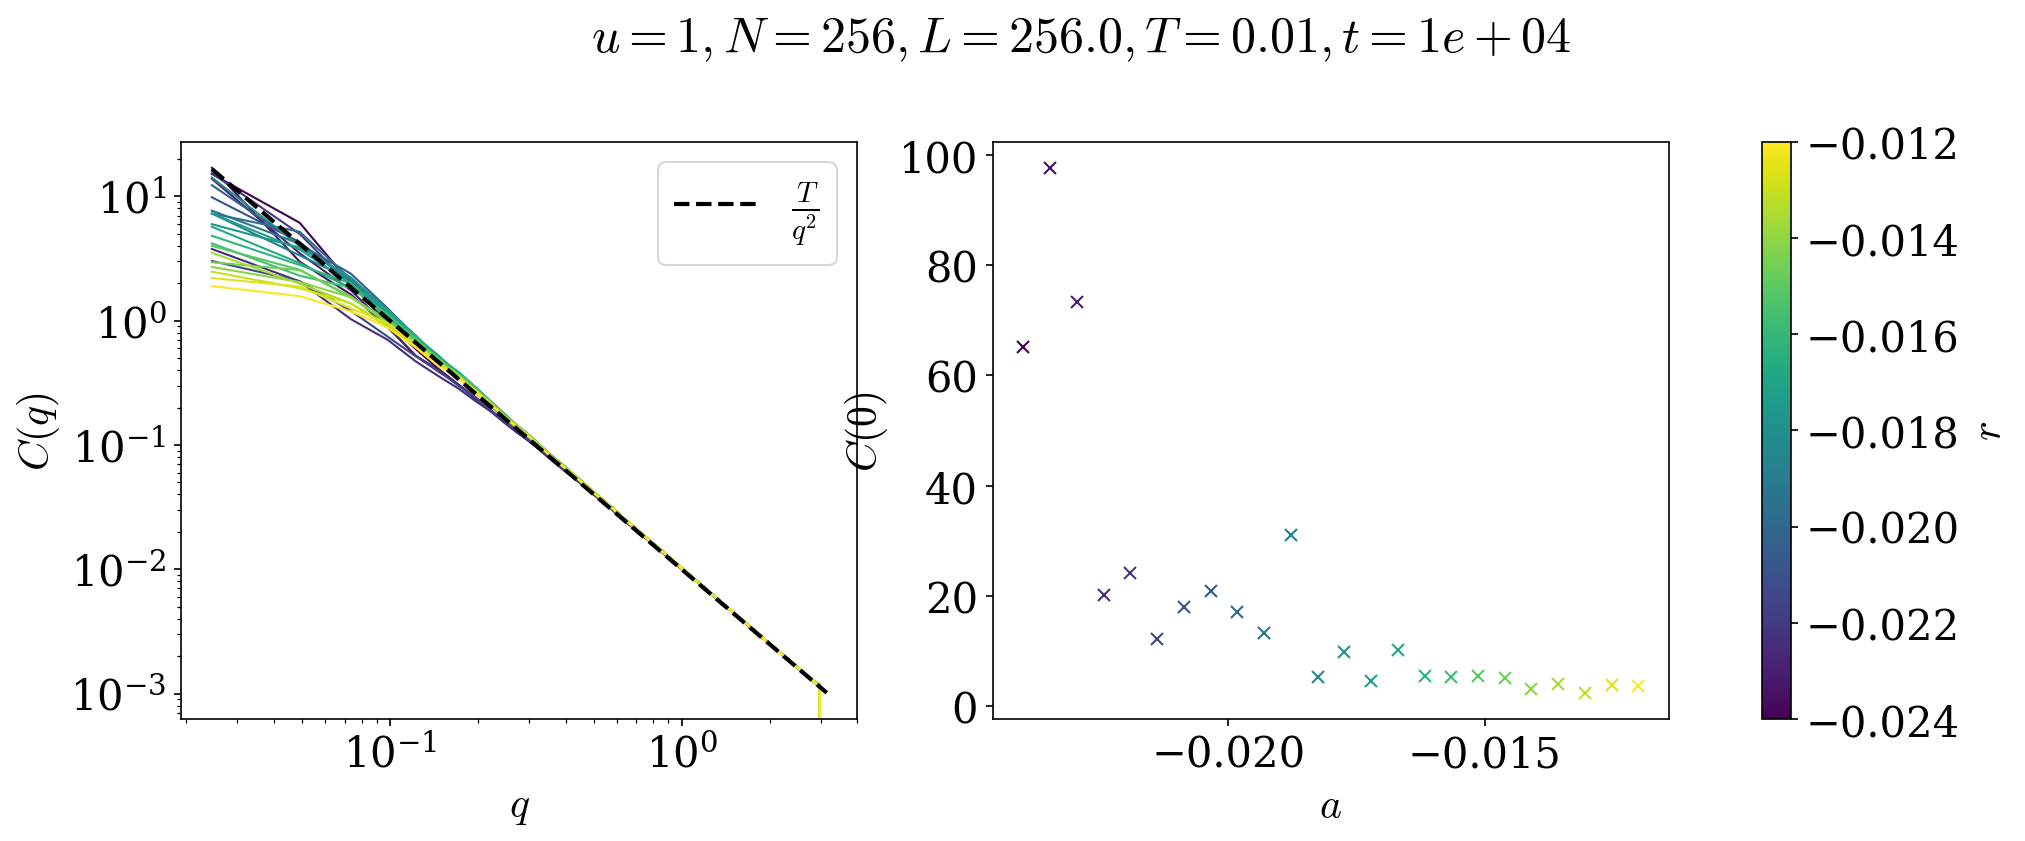

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))

rr = []
xs = []
for i in range(n):
    q, Cqvec, CqvecMasked, con, T, L, N, lim = get_data_single(i + 1, folder, 10)
    Cq, q0 = average_q(Cqvec, q, N, L)
    
    r = con["r"]
    rr.append(r)
    color = cm.viridis(i/(n-1))
    title = "$r = {r:.3f}$".format(r=r)
    
    ax[0].loglog(q0[1:], Cq[1:], lw=1., ls="-", color=color, zorder=0)
    x = Cq[0]
    xs.append(x)
    p = ax[1].plot(r, x, 'x', color=color)


q, Cqvec, CqvecMasked, con, T, L, N, lim = get_data_single(1, folder, -1)
Cq, q0 = average_q(Cqvec, q, N, L)
u = con["u"]
ax[0].plot(q0[1:], T*q0[1:]**(-2), 'k--', label="$\\frac{T}{q^2}$")

title = "$u = {u}, N = {N}, L = {L}, T={T}, t={t:1.0e} $".format(u=u,N=N,L=L, T=T,t=time[-1])

fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=np.min(rr), vmax=np.max(rr)), cmap=cm.viridis), ax=ax, label="$r$")
fig.suptitle(title, y=1.05)
ax[0].legend()
ax[0].set_ylabel("$C(q)$")
ax[0].set_xlabel("$q$")
ax[1].set_ylabel("$C(0)$")
ax[1].set_xlabel("$a$")

plt.show()

/tmp/ipykernel_1905439/2048902346.py:9: RuntimeWarning: divide by zero encountered in divide
  ax[0].loglog(np.abs(rr-rc)[ic:], xs[mm] * np.abs((rr[mm] - rc)/(rr - rc))[ic:]**gamma, 'k', label="$1 / r^\\gamma$")


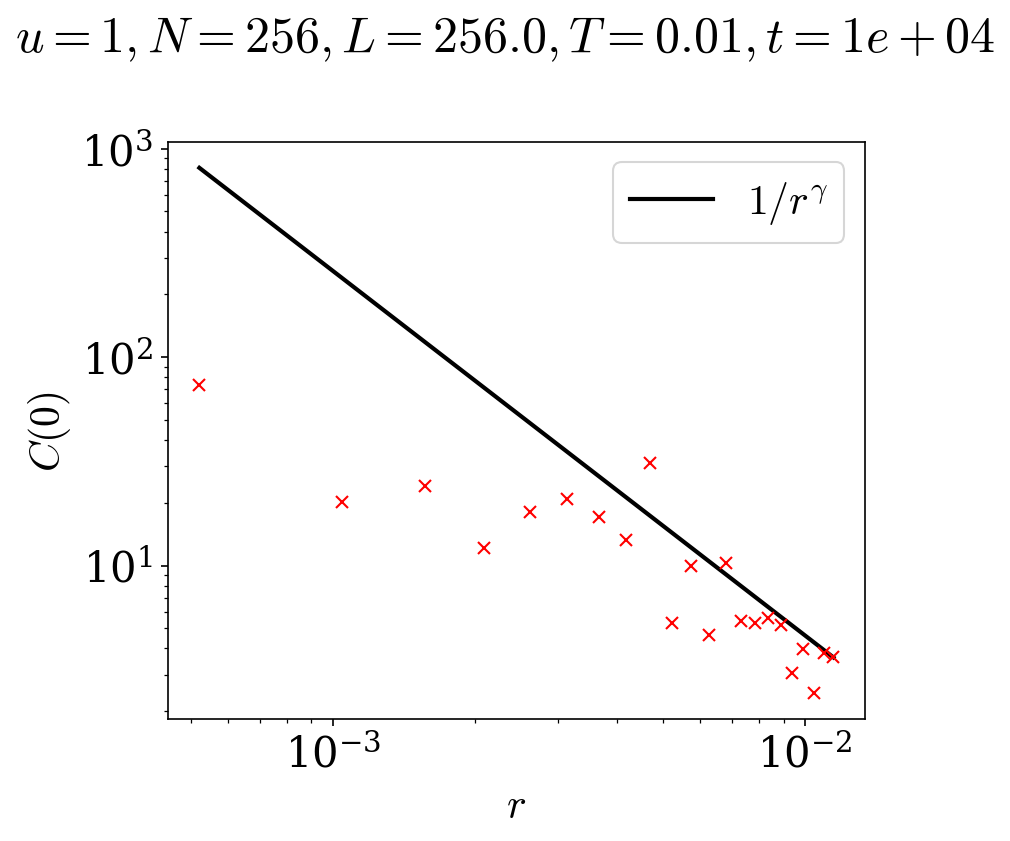

In [18]:
ic = np.argmax(xs)
rc  = rr[ic]

fig, ax = plt.subplots(1, figsize=(6,5))
ax = [ax,]

gamma = 7/4
mm = -1
ax[0].loglog(np.abs(rr-rc)[ic:], xs[mm] * np.abs((rr[mm] - rc)/(rr - rc))[ic:]**gamma, 'k', label="$1 / r^\\gamma$")
ax[0].loglog(np.abs(rr-rc)[ic:], xs[ic:], 'rx')
ax[0].legend()

q, Cqvec, CqvecMasked, con, T, L, N, lim = get_data_single(1, folder, -1)
u = con["u"]

title = "$u = {u}, N = {N}, L = {L}, T={T}, t={t:1.0e} $".format(u=u,N=N,L=L, T=T,t=time[-1])
fig.suptitle(title,y=1.05)

ax[0].set_ylabel("$C(0)$")
ax[0].set_xlabel("$r$")

plt.show()

# Correlation Length

/tmp/ipykernel_1905439/3712218277.py:21: RuntimeWarning: divide by zero encountered in power
  f = lambda q, A, B, xi : A / (1 + (xi * q)**B )


$u = 1, N = 256, L = 256.0, T=0.01, t=1e+04 $


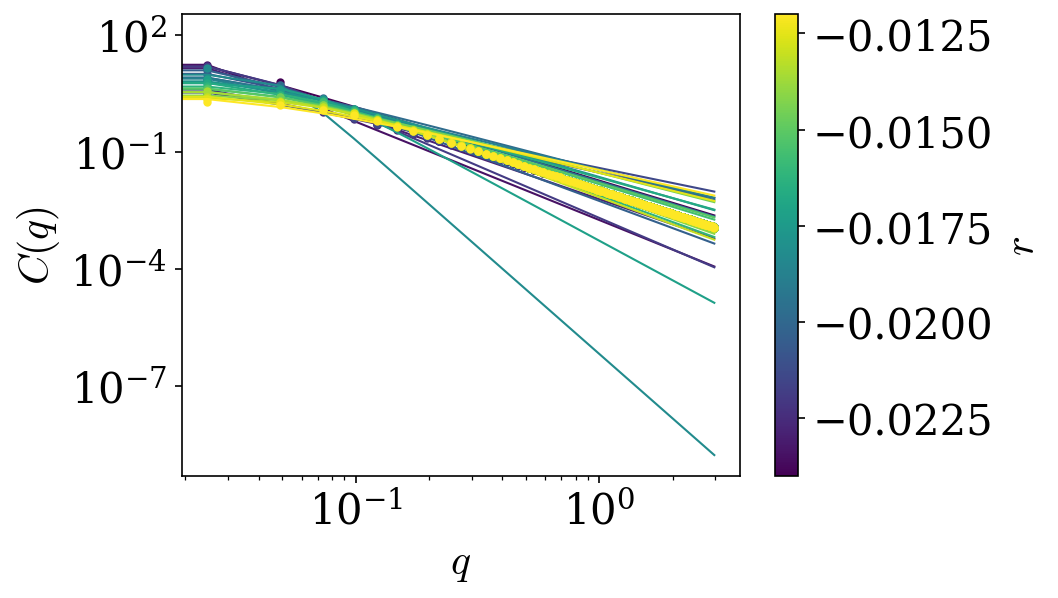

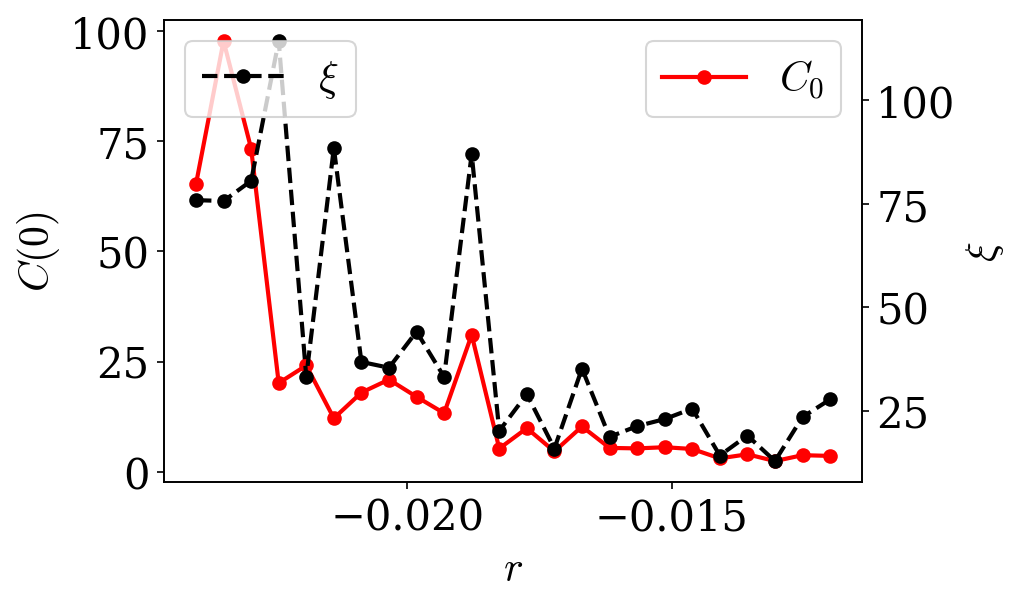

In [19]:
from numpy import log as ln
from scipy.optimize import curve_fit

fig1, ax0 = plt.subplots(figsize=(6,4))
fig2, ax1 = plt.subplots(figsize=(6,4))
ax = [ax0, ax1]

xi = []
rr = []
xs = []

ax2 = ax[1].twinx()
nn = 1
for j in range(0, n, nn):

    q, Cqvec, CqvecMasked, con, T, L, N, lim = get_data_single(1 + j, folder, 10)
    Cq, q0 = average_q(Cqvec, q, N, L)
    Cq, q0 = Cq[(Cq!=0)], q0[(Cq!=0)]
    r = con["r"]

    f = lambda q, A, B, xi : A / (1 + (xi * q)**B )
    p = curve_fit(f, q0, Cq)

    xx = p[0][2]
    xi.append(xx)
    xs.append(Cq[0])
    rr.append(r)
    color = cm.viridis(j/(n-1))
    if j%1==0:
        ax[0].loglog(q0, f(q0, *p[0]), color=color, lw=1.)
        ax[0].loglog(q0, Cq, 'o', ms=3, color=color)

    ax2.plot(r, xx, '.', color=color)

ax[1].plot(rr, xs, 'r-', marker="o", lw=2, label="$C_0$")
ax2.plot(rr, xi, 'k--', marker="o", lw=2, label="$\\xi$")

title = "$u = {u}, N = {N}, L = {L}, T={T}, t={t:1.0e} $".format(u=u,N=N,L=L, T=T,t=time[-1])
print(title)

ax[0].set_ylabel("$C(q)$")
ax[0].set_xlabel("$q$")
ax[1].set_xlabel("$r$")
ax[1].set_ylabel("$C(0)$")
ax2.set_ylabel("$\\xi$")
ax[1].legend(loc=1)
ax2.legend(loc=2)

fig1.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=np.min(rr), vmax=np.max(rr)), cmap=cm.viridis), ax=ax[0], label="$r$",)
fig2.savefig("fig/SETD_paper_fig2.pdf", bbox_inches="tight")


In [20]:
ic = np.argmax(xi)
rc  = rr[ic]
# We skip points with xi > L/2, as this is unreliable
# Correlation lenghts can be more than half system 
# due to conservation law
nn = np.where(xi[ic:] < L/2)[0][0]
print(nn)
print(xi[ic+nn])

0
114.3083550429698


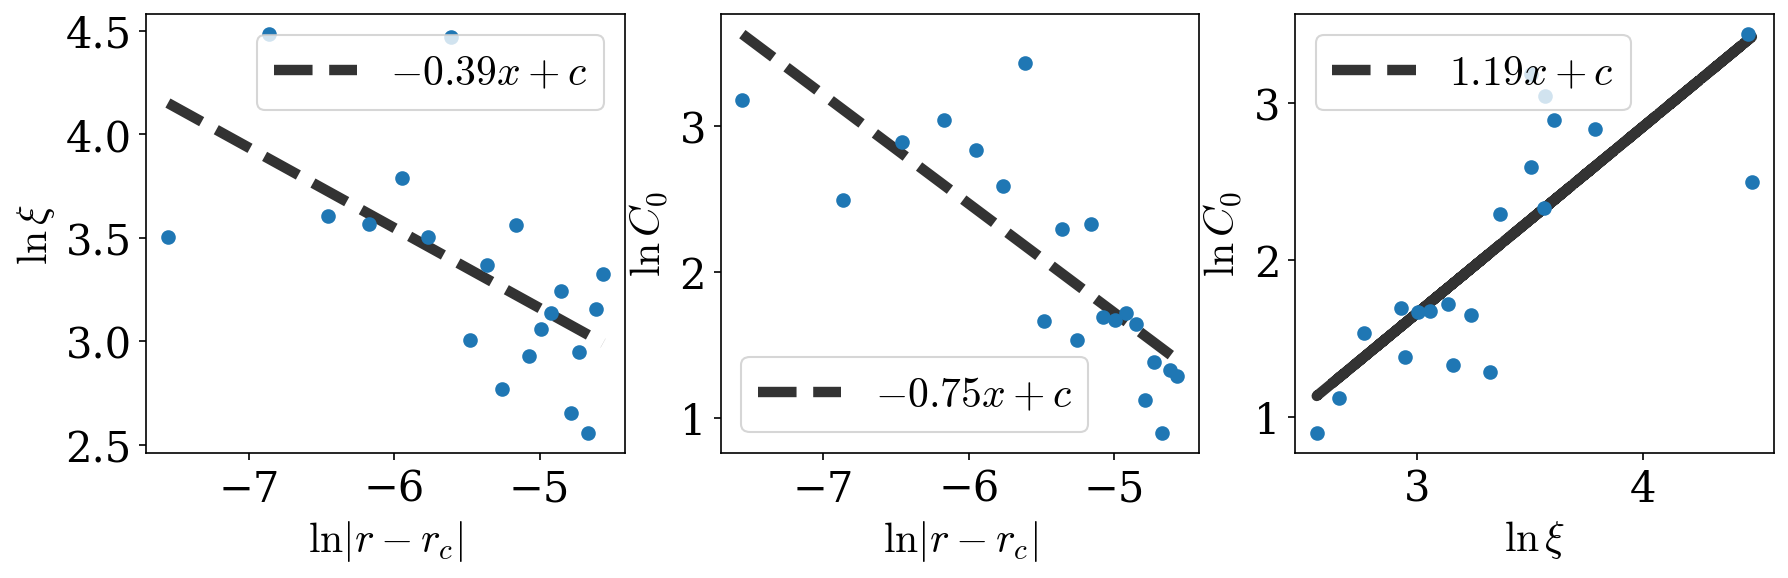

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(14, 3.8))
line_alpha  = 0.8
ms          = 6
f = lambda X, a, b : a * X + b 

x = ln(np.abs(rr-rc)[ic+1:])
y = ln(xi[ic+1:])
xx, yy = x[nn:], y[nn:]
p = curve_fit(f, xx, yy)[0]
label = "${p1:.2f}x + c$".format(p1=p[0],p2=p[1])

ax[0].plot(xx, yy, 'o', ms=ms)
ax[0].plot(xx, f(xx, *p), 'k--', lw=5, label=label, alpha=line_alpha, zorder=0)
ax[0].legend()
ax[0].set_xlabel("$\\ln |r - r_c|$")
ax[0].set_ylabel("$\\ln \\xi$")

x = ln(np.abs(rr-rc)[ic+1:])
y = ln(xs[ic+1:])
xx, yy = x[nn:], y[nn:]
p = curve_fit(f, xx, yy)[0]
label = "${p1:.2f} x +c$".format(p1=p[0],p2=p[1])

ax[1].plot(xx, yy, 'o', ms=ms)
ax[1].plot(xx, f(xx, *p), 'k--', lw=5, label=label, alpha=line_alpha, zorder=0)
ax[1].legend()
ax[1].set_xlabel("$\\ln |r - r_c|$")
ax[1].set_ylabel("$\\ln C_0$")

x = ln(xi[ic+1:])
y = ln(xs[ic+1:])
xx, yy = x[nn:], y[nn:]
p = curve_fit(f, xx, yy)[0]
label = "${p1:.2f} x + c$".format(p1=p[0],p2=p[1])

ax[2].plot(xx, yy, 'o', ms=ms)
ax[2].plot(xx, f(xx, *p), 'k--', lw=5, label=label, alpha=line_alpha, zorder=0)
ax[2].legend()
ax[2].set_xlabel("$\\ln \\xi$")
ax[2].set_ylabel("$\\ln C_0$")

fig.savefig("fig/figexp.pdf", bbox_inches="tight")